# User models in Sherpa

I was recently working on a way to characterize the draws from a 
[MCMC chain](http://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo) - in this
case generated with
[pyBLoCXS](http://cxc.harvard.edu/sherpa/ahelp/pyblocxs.html) but that's only relevant
here because we are interested in Poisson-distributed data, hence the Gamma function -
and came up with a simple user model for
[Sherpa](http://cxc.harvard.edu/sherpa/). I thought it would be make a good example case,
and decided to include an example of using the "low-level" API of Sherpa to fit data.

## Follow ups

I have written a follow-up to this, available at
[an integrated user model](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/an%20integrated%20user%20model.ipynb). This was written on May 4 2015.

I then had a brain wave and decided to talk about
[plotting in Sherpa when using the low-level API](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/plotting%20using%20the%20lower-level%20routines.ipynb). This was written on May 5 2015.

The code has since been updated to match new Sherpa releases (either standalone or as part of CIAO, which you can now
install with conda which makes using it in a notebook a lot easier).

The standaone version of Sherpa now has its own [web site with documentation](https://sherpa.readthedocs.io/).

## Author and disclaimer

This was written by 
[Douglas Burke](http://hea-www.cfa.harvard.edu/~dburke/)
on May 26 2015. This notebook, and others that may be of
interest, can be found on GitHub at
https://github.com/DougBurke/sherpa-standalone-notebooks.

The information in this document is placed into the Publc Domain. It is not an official product of the Chandra
X-ray Center, and I make no guarantee that it is not without bugs or embarassing typos. Please contact me via the GitHub repository
if you have any questions. 

## Last run

When was this notebook last run?

In [1]:
import datetime
datetime.datetime.now().strftime("%Y-%m-%d %H:%M")

'2024-01-02 11:26'

In [2]:
import sherpa
sherpa.__version__

'4.16.0'

## Setting up

In [3]:
import scipy.stats
import matplotlib.pyplot as plt
import numpy as np

In [4]:
%matplotlib inline

To make my testing easier, I fix the random seed. It's the same value as used by 
[Jake's AstroML book](http://www.astroml.org/book_figures/chapter3/fig_flux_errors.html),
but you may want to use a different value yourself ;-)

Prior to January 2024 this used `np.random.seed(1)` and did not send the `rng` value to the `rvs` call below, which resulted in a different-set of values.

In [5]:
rng = np.random.default_rng(1)

## Simulating some data

For this example, I am going to simulate values from a Gamma distribution using
[`scipy.stats.gamma`](http://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.stats.gamma.html).
Following the 
[Wikipedia page](http://en.wikipedia.org/wiki/Gamma_distribution) I use the names `k` and `theta`
for the parameters of the distribution; fortunately they map onto the `a` and `scale` values used
by `scipy.stats.gamma`.

The mean of the distribution is just `k * theta`, so `2.86` here:

In [6]:
k_orig = 1.1
theta_orig = 2.6
ysim = scipy.stats.gamma.rvs(a=k_orig, scale=theta_orig, size=1000, random_state=rng)

Let's have a quick look at the data:

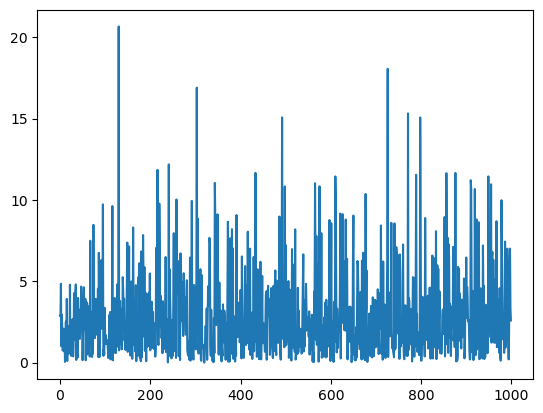

In [7]:
plt.plot(ysim);

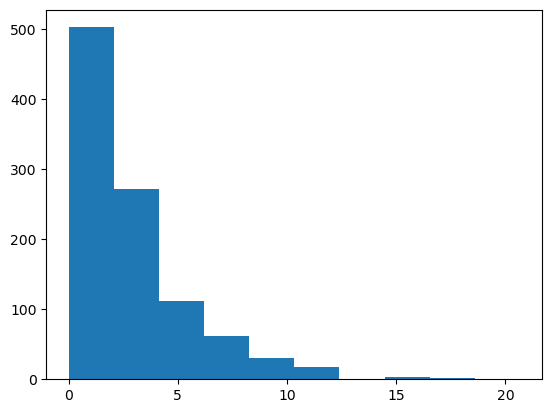

In [8]:
plt.hist(ysim);

For the work I was doing, I was interested in the 
[Cumulative Distribution Function](http://en.wikipedia.org/wiki/Cumulative_distribution_function),
so let's start by creating this for the data (`ysim`):

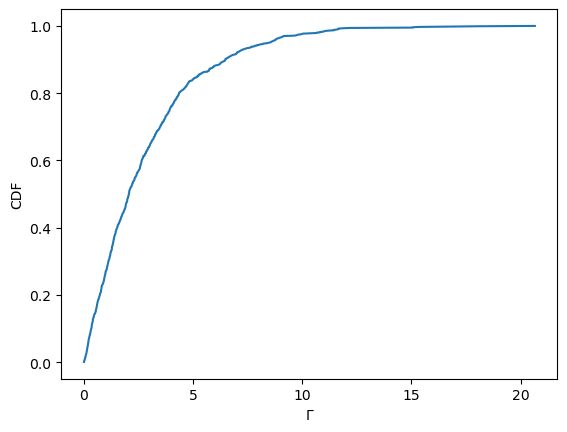

In [9]:
xcdf = ysim.copy()
xcdf.sort()
ycdf = np.arange(1, xcdf.size+1) * 1.0 / xcdf.size

plt.plot(xcdf, ycdf)
plt.xlabel('$\Gamma$')
plt.ylabel('CDF');

My aim is to fit this data, so I need a functional form for the CDF of
a Gamma distribution. Fortunately Sherpa provides the `igam` routine
which calculates what we need, so I can write the following (I could
have also used `scipy.stats` routines, but I wanted this to be usable
from Sherpa in CIAO):

In [10]:
import sherpa.utils

In [11]:
def calc_gamma_cdf(x, k, theta):
    """Return the CDF of a gamma distribution.

    The cumulative distribution function (CDF) of the gamma
    distribution is defined in [1]_ as::

       cdf(x;k,theta) = incomplete_gamma(k, x/theta)
                        ----------------------------
                                  gamma(k)

    Parameters
    ----------
    x : array
       The values at which to evaluate the CDF.
    k : number
       The shape parameter, which must be greater than 0.
    theta : number
       The scale parameter.

    Returns
    -------
    cdf : array
       The CDF evaluated at each element of x.

    Notes
    -----
    The mean of the distribution is given by ``k * theta``,
    and the rate is ``1 / theta``.
 
    References
    ----------

    .. [1] http://en.wikipedia.org/wiki/Gamma_distribution

    """

    # Unfortunately igam does not accept a Numpy array as the
    # second argument, so need to map over the input array.
    #
    tval = theta * 1.0
    kval = k * 1.0
    x = np.asarray(x)
    out = np.zeros_like(x)
    for i,xi in enumerate(x):
        # igam is the "regularized" incomplete gamma (lower)
        # form, so already has the normalization by gamma(a)
        # included.
        out[i] = sherpa.utils.igam(kval, xi/tval)

    return out

I can use this to plot the actual distribution on the simulated one:

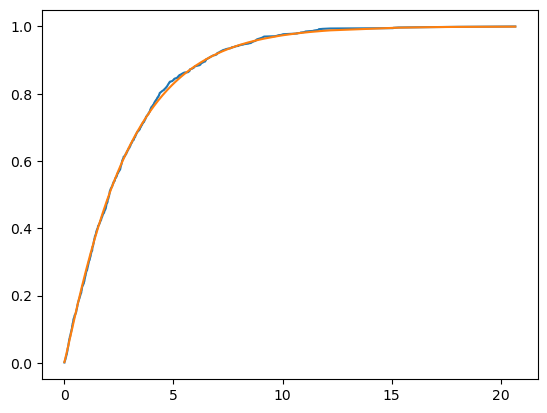

In [12]:
plt.plot(xcdf, ycdf)
plt.plot(xcdf, calc_gamma_cdf(xcdf, k_orig, theta_orig));

The [Quantile-Quantile plot](http://en.wikipedia.org/wiki/Q%E2%80%93Q_plot)
also looks good (as it should here ;-):

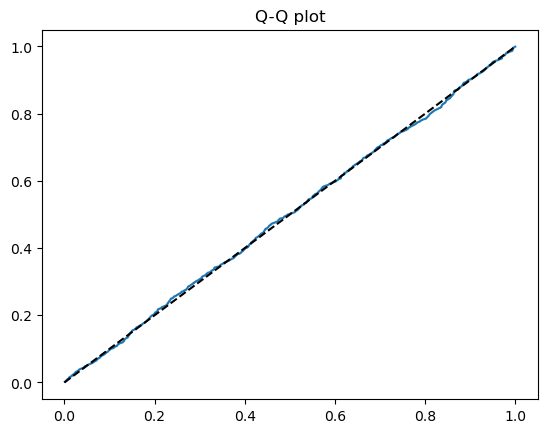

In [13]:
plt.plot(ycdf, calc_gamma_cdf(xcdf,k_orig,theta_orig))
plt.plot([0,1],[0,1], 'k--')
plt.title('Q-Q plot');

Using `calc_gamma_cdf` I can now create a Sherpa model that can be used to
fit the CDF data. Rather than use the
[`load_user_model` function](http://cxc.harvard.edu/sherpa/ahelp/load_user_model.html),
I have decided to use a class-based approach. The advantage is that this model then
behaves in the same manner as existing Sherpa models - so that you can create multiple
instances of it directly - at the expense of a little-more set-up work.

To do this, I need to import the Sherpa `sherpa.models.model` module.
In this case I am being explicit about the module names, to make it easier to see where
symbols are defined, but normally I would say something like

    from sherpa.models import model

In [14]:
import sherpa.models.model

With this, I can create the `GammaCDF` class. The model has two parameters, which 
I name `k` and `theta`, and set initial parameters and limits (the limit is inclusive,
which is not ideal here because both should be `> 0` rather than `>= 0`, but let's
see how this works). The important parts are `__init__`, which sets everything
up, and `calc` which is used to evaluate the model at a set of points. For this
example I am going to assume that if it is used with an "integrated" 1D data set - that
is, a data set where the signal is integrated between bin limits, rather than just
a value at a point - then the code should just use the mid-point of the bin. The
`modelCacher1d` function decorator tells the system that the results of the model can
be cached when all the parameter values are frozen (e.g. during a fit).

In [15]:
class GammaCDF(sherpa.models.model.ArithmeticModel):
    """A Gamma CDF.

    The cumulative distribution function (CDF) for the Gamma
    distribution, as defined by [1]_, is::

       cdf(x;k,theta) = incomplete_gamma(k, x/theta)
                        ----------------------------
                                  gamma(k)

    The model parameters are:

    k
       The shape parameter, which must be greater than 0.

    theta
       The scale parameter.

    Notes
    -----
    The mean of the distribution is given by ``k * theta``,
    and the rate is ``1 / theta``.
 
    References
    ----------

    .. [1] http://en.wikipedia.org/wiki/Gamma_distribution

    """

    # The Sherpa 4.12.2 release adds support for checking model dimensionality
    ndim = 1
    "A one-dimensional model"
    
    def __init__(self, name='gammacdf'):
        # It would be nice to force > 0 rather than >=0.
        # Perhaps should just use a small value, e.g. 
        # sherpa.models.parameter.tinyval?
        self.k = sherpa.models.model.Parameter(name, 'k', 5, min=0, hard_min=0)
        self.theta = sherpa.models.model.Parameter(name, 'theta', 2, min=0, hard_min=0)

        sherpa.models.model.ArithmeticModel.__init__(self, name, (self.k, self.theta))

    @sherpa.models.model.modelCacher1d
    def calc(self, pars, x, *args, **kwargs):
        (k, theta) = pars
        if len(args) == 1:
            x = (x + args[0]) / 2.0

        return calc_gamma_cdf(x, k, theta)


This model can be used to fit the data. I'll show this two ways

 1. using the low-level API, where data management is not automatic
 
 2. using the high-level UI which most users of Sherpa are used to.

## Managing the data directly

The UI that is explained in the 
[CXC Sherpa documentation](http://cxc.harvard.edu/sherpa/) deals with 
data management and state. However, this can be handled directly by
dropping down to the individual models and - for some cases, such as this
one - is very easy to do. Let's start with importing the symbols I need
(and to make it look easy, I'm not going to use the fully-qualified name approach I've
used so far):

In [16]:
from sherpa.data import Data1D
from sherpa.stats import LeastSq
from sherpa.optmethods import LevMar
from sherpa.fit import Fit

For this example - which is a 1D un-binned data set - we just need a name, and the independent and dependent data arrays. The name is only used to label the results in output structures, so here I just use the label `cdf`.

In [17]:
d = Data1D('cdf', xcdf, ycdf)

The model to be fit is - in this case - just a single component, the newly-created `GammaCDF`
model, so I need an instance (the name need not be the same as the variable name, but it makes tracking
things a bit easier!):

In [18]:
cdf = GammaCDF('cdf')

With these, I can now create a `Fit` object, selecting the statistic - I use the least-squared
version (`LeastSq`) since I have no errors - and the optimiser, for which I use the 
Levenberg-Marquardt method (as provided by the `LevMar` class):

In [19]:
f = Fit(d, cdf, LeastSq(), LevMar())

The fit can then be "run" and the output stored away. For this case the optimiser converged.

In [20]:
res = f.fit()
res.succeeded

True

The output of the `fit` method returns a lot if useful information, including the best-fit parameter values:

In [21]:
res

Parameter,Best-fit value,Approximate error
cdf.k,1.12594,± 0.33594
cdf.theta,2.53021,± 0.997753


However, we can also access these values directly from the model:

In [22]:
cdf

<GammaCDF model instance 'cdf'>

and compare them to the input values:

In [23]:
print(cdf.k.val, cdf.theta.val)
print(k_orig, theta_orig)

1.125938433055331 2.5302092204268933
1.1 2.6


One down side to the low-level API is that plots have to be manually
created, but it's quite easy to create a residual (i.e. fit - data)
plot for the CDF (after writing this section I added a new notebook,
[Plotting using the "low-level" interface](http://nbviewer.jupyter.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/plotting%20using%20the%20lower-level%20routines.ipynb),
which shows how you can use the Sherpa plotting infrastructure to
make these plots):

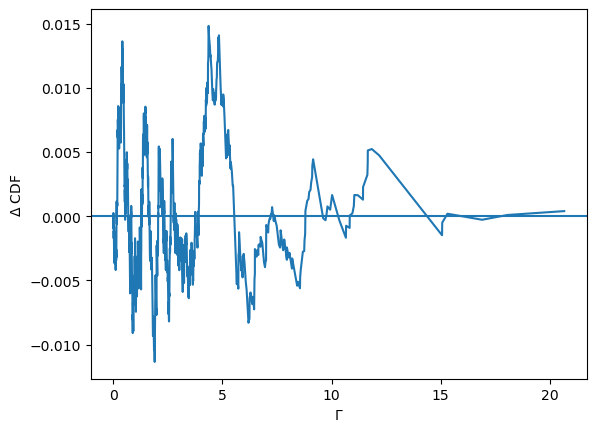

In [24]:
plt.plot(xcdf, ycdf - cdf(xcdf))
plt.axhline()
plt.ylabel('$\Delta$ CDF')
plt.xlabel('$\Gamma$');

The QQ plot looks good, as might be expected from the residuals:

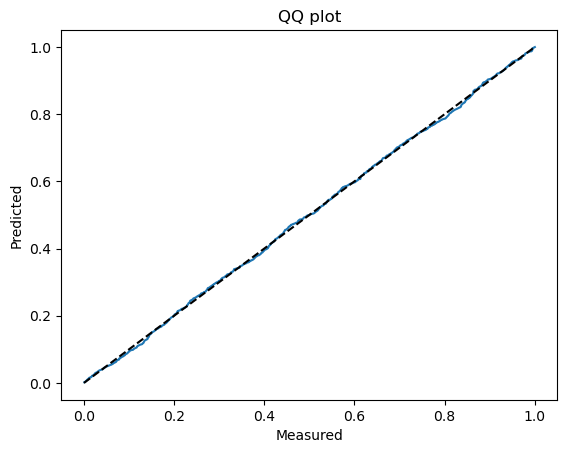

In [25]:
plt.plot(ycdf, cdf(xcdf))
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('QQ plot');

## Letting Sherpa do all the work

The high-level API of Sherpa manages data and settings for users. In the
following I'm going to use the version provided by the `sherpa.ui` module,
but the "Astronomy-specific" module `sherpa.astro.ui` can also be used.

In [26]:
import sherpa.ui

The model needs to be added to Sherpa using `add_model`:

In [27]:
sherpa.ui.add_model(GammaCDF)

Let's select the least-square statistic, by name:

In [28]:
sherpa.ui.set_stat('leastsq')

Rather than create a `Data1D` object, here I use the default data set - which is
labelled `1`:

In [29]:
sherpa.ui.load_arrays(1, xcdf, ycdf)

The default behavior in plots is to display error bars, even when using a statistic like `leastsq`,
so I change this behavior before displaying the data:

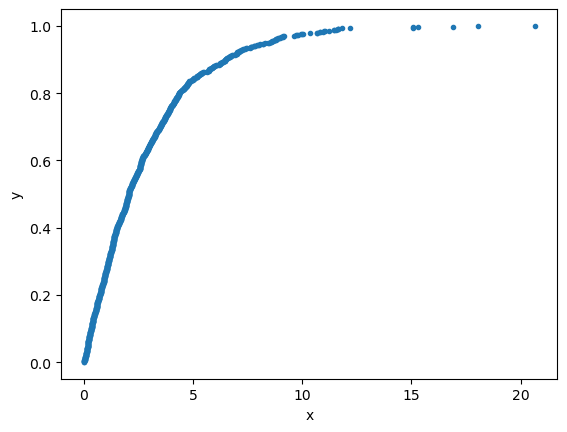

In [30]:
pprefs = sherpa.ui.get_plot_prefs('data')
pprefs['yerrorbars'] = False
sherpa.ui.plot_data()

The source model, used to describe the data, is set by `set_source`. Since `add_model` was used,
I can create an instance of the `GammaCDF` model using the syntax `modelname.cptname`, where
`modelname` is in lower case. To allow comparison with the eariler fit, I name the component
`cpt2`:

In [31]:
sherpa.ui.set_source(gammacdf.cdf2)

In [32]:
cdf2

<GammaCDF model instance 'gammacdf.cdf2'>

The defailt optimiser is `LevMar`, so I do not need to set it - which would have been the following
call

    set_method('levmar')
    
Instead I can just go straight to fitting the data:

In [33]:
sherpa.ui.fit()

Dataset               = 1
Method                = levmar
Statistic             = leastsq
Initial fit statistic = 238.936
Final fit statistic   = 0.0284038 at function evaluation 26
Data points           = 1000
Degrees of freedom    = 998
Change in statistic   = 238.907
   cdf2.k         1.12594      +/- 0.33594     
   cdf2.theta     2.53021      +/- 0.997753    


and view the results:

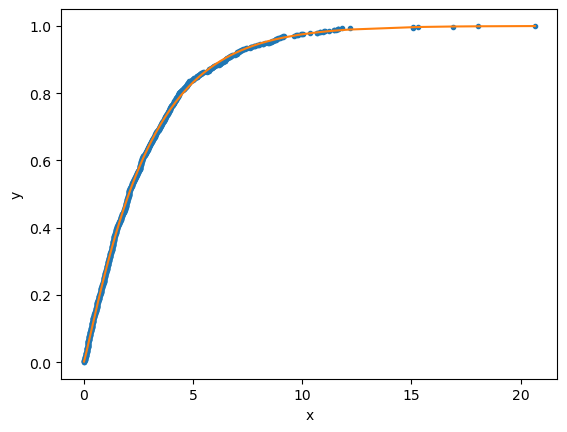

In [34]:
sherpa.ui.plot_fit()

Unfortunately it's not that obvious what is going on here, so let's look at the residual plot:

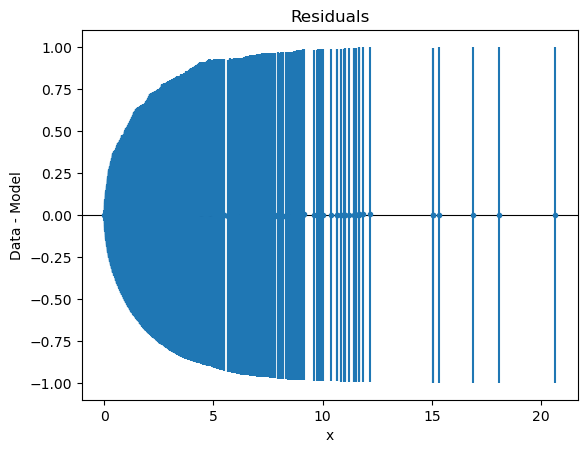

In [35]:
sherpa.ui.plot_resid()

We can turn off the error bars for the residual plot too:

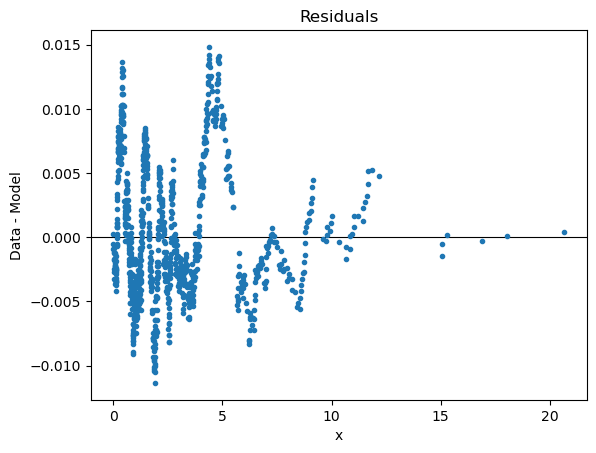

In [36]:
sherpa.ui.get_plot_prefs('resid')['yerrorbars'] = False
sherpa.ui.plot_resid()

In [37]:
The results of the two fits should be the same (since the data, model, and starting points are the same). Are they?

Object `they` not found.


In [38]:
cdf

<GammaCDF model instance 'cdf'>

In [39]:
cdf2

<GammaCDF model instance 'gammacdf.cdf2'>

Phew. So, I hope you enjoyed this whistle-stop tour through Sherpa user models, the
`add_model` command, and direct access to the low-level API provided by Sherpa.

## A follow up (May 4th and 5th, 2015)

I have written a follow-up to this, available at
[an integrated user model](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/an%20integrated%20user%20model.ipynb), and then a notebook about
[plotting in Sherpa when using the low-level API](http://nbviewer.ipython.org/github/DougBurke/sherpa-standalone-notebooks/blob/master/plotting%20using%20the%20lower-level%20routines.ipynb).